# # 플라스크 실행용 코드
---

## # 모델 불러오기
---

In [6]:
import glob
import os.path
import sys
from collections import namedtuple
import torch
from omegaconf import OmegaConf

sys.path.append('/data/kimgh/ImEzy/stable-diffusion-flask/repositories/stable-diffusion')
from ldm.util import instantiate_from_config

from modules import shared

CheckpointInfo = namedtuple("CheckpointInfo", ['filename', 'title', 'hash', 'model_name'])
checkpoints_list = {}

try:
    # this silences the annoying "Some weights of the model checkpoint were not used when initializing..." message at start.

    from transformers import logging

    logging.set_verbosity_error()
except Exception:
    pass


def checkpoint_tiles():
    return sorted([x.title for x in checkpoints_list.values()])


def list_models():
    checkpoints_list.clear()

    model_dir = os.path.abspath(shared.cmd_opts.ckpt_dir)

    def modeltitle(path, h):
        abspath = os.path.abspath(path)

        if abspath.startswith(model_dir):
            name = abspath.replace(model_dir, '')
        else:
            name = os.path.basename(path)

        if name.startswith("\\") or name.startswith("/"):
            name = name[1:]

        shortname = os.path.splitext(name.replace("/", "_").replace("\\", "_"))[0]

        return f'{name} [{h}]', shortname

    cmd_ckpt = shared.cmd_opts.ckpt
    if os.path.exists(cmd_ckpt):
        h = model_hash(cmd_ckpt)
        title, model_name = modeltitle(cmd_ckpt, h)
        checkpoints_list[title] = CheckpointInfo(cmd_ckpt, title, h, model_name)
    elif cmd_ckpt is not None and cmd_ckpt != shared.default_sd_model_file:
        print(f"Checkpoint in --ckpt argument not found: {cmd_ckpt}", file=sys.stderr)

    if os.path.exists(model_dir):
        for filename in glob.glob(model_dir + '/**/*.ckpt', recursive=True):
            h = model_hash(filename)
            title, model_name = modeltitle(filename, h)
            checkpoints_list[title] = CheckpointInfo(filename, title, h, model_name)
            
    # return checkpoints_list


def model_hash(filename):
    try:
        with open(filename, "rb") as file:
            import hashlib
            m = hashlib.sha256()

            file.seek(0x100000)
            m.update(file.read(0x10000))
            return m.hexdigest()[0:8]
    except FileNotFoundError:
        return 'NOFILE'


def select_checkpoint():
    model_checkpoint = shared.opts.sd_model_checkpoint
    checkpoint_info = checkpoints_list.get(model_checkpoint, None)
    if checkpoint_info is not None:
        return checkpoint_info

    if len(checkpoints_list) == 0:
        print(f"No checkpoints found. When searching for checkpoints, looked at:", file=sys.stderr)
        print(f" - file {os.path.abspath(shared.cmd_opts.ckpt)}", file=sys.stderr)
        print(f" - directory {os.path.abspath(shared.cmd_opts.ckpt_dir)}", file=sys.stderr)
        print(f"Can't run without a checkpoint. Find and place a .ckpt file into any of those locations. The program will exit.", file=sys.stderr)
        exit(1)

    checkpoint_info = next(iter(checkpoints_list.values()))
    if model_checkpoint is not None:
        print(f"Checkpoint {model_checkpoint} not found; loading fallback {checkpoint_info.title}", file=sys.stderr)

    return checkpoint_info


def load_model_weights(model, checkpoint_file, sd_model_hash):
    print(f"Loading weights [{sd_model_hash}] from {checkpoint_file}")

    pl_sd = torch.load(checkpoint_file, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]

    model.load_state_dict(sd, strict=False)

    if shared.cmd_opts.opt_channelslast:
        model.to(memory_format=torch.channels_last)

    if not shared.cmd_opts.no_half:
        model.half()

    model.sd_model_hash = sd_model_hash
    model.sd_model_checkpint = checkpoint_file
    

def load_model():
    from modules import lowvram, sd_hijack
    list_models() # 수정
    checkpoint_info = select_checkpoint()

    sd_config = OmegaConf.load(shared.cmd_opts.config)
    sd_model = instantiate_from_config(sd_config.model)
    load_model_weights(sd_model, checkpoint_info.filename, checkpoint_info.hash)

    if shared.cmd_opts.lowvram or shared.cmd_opts.medvram:
        lowvram.setup_for_low_vram(sd_model, shared.cmd_opts.medvram)
    else:
        sd_model.to(shared.device)

    sd_hijack.model_hijack.hijack(sd_model)

    sd_model.eval()

    print(f"Model loaded.")
    return sd_model


def reload_model_weights(sd_model, info=None):
    from modules import lowvram, devices
    checkpoint_info = select_checkpoint()

    if sd_model.sd_model_checkpint == checkpoint_info.filename:
        return

    if shared.cmd_opts.lowvram or shared.cmd_opts.medvram:
        lowvram.send_everything_to_cpu()
    else:
        sd_model.to(devices.cpu)

    load_model_weights(sd_model, checkpoint_info.filename, checkpoint_info.hash)

    if not shared.cmd_opts.lowvram and not shared.cmd_opts.medvram:
        sd_model.to(devices.device)

    print(f"Weights loaded.")
    return sd_model

shared.sd_model = load_model()

LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loading weights [7460a6fa] from /data/kimgh/ImEzy/stable-diffusion-flask/models/sd-v1-4.ckpt
Global Step: 470000
Model loaded.


## # txt2img
---

In [5]:
import modules.scripts
from modules.processing import StableDiffusionProcessing, Processed, StableDiffusionProcessingTxt2Img, StableDiffusionProcessingImg2Img, process_images
from modules.shared import opts, cmd_opts
import modules.shared as shared
import modules.processing as processing
from modules.ui import plaintext_to_html


def txt2img(prompt: str, negative_prompt: str, prompt_style: str, prompt_style2: str, steps: int, sampler_index: int, restore_faces: bool, tiling: bool, n_iter: int, batch_size: int, cfg_scale: float, seed: int, subseed: int, subseed_strength: float, seed_resize_from_h: int, seed_resize_from_w: int, seed_enable_extras: bool, height: int, width: int, enable_hr: bool, scale_latent: bool, denoising_strength: float, *args):
    # global shared.sd_model
    p = StableDiffusionProcessingTxt2Img(
        sd_model=shared.sd_model,
        # sd_model=load_model(),
        outpath_samples=opts.outdir_samples or opts.outdir_txt2img_samples,
        outpath_grids=opts.outdir_grids or opts.outdir_txt2img_grids,
        prompt=prompt,
        styles=[prompt_style, prompt_style2],
        negative_prompt=negative_prompt,
        seed=seed,
        subseed=subseed,
        subseed_strength=subseed_strength,
        seed_resize_from_h=seed_resize_from_h,
        seed_resize_from_w=seed_resize_from_w,
        seed_enable_extras=seed_enable_extras,
        sampler_index=sampler_index,
        batch_size=batch_size,
        n_iter=n_iter,
        steps=steps,
        cfg_scale=cfg_scale,
        width=width,
        height=height,
        restore_faces=restore_faces,
        tiling=tiling,
        enable_hr=enable_hr,
        scale_latent=scale_latent if enable_hr else None,
        denoising_strength=denoising_strength if enable_hr else None,
    )

    print(f"\ntxt2img: {prompt}", file=shared.progress_print_out)
    processed = modules.scripts.scripts_txt2img.run(p)

    if processed is None:
        processed = process_images(p)

    shared.total_tqdm.clear()

    generation_info_js = processed.js()
    if opts.samples_log_stdout:
        print(generation_info_js)

    return processed.images, generation_info_js, plaintext_to_html(processed.info)

### # 파라미터
----

In [3]:
prompt = 'autumn' # 사용자 입력
negative_prompt = '' # 사용자 입력
prompt_style = 'oil painting'
prompt_style2 = 'space'
steps = 20
sampler_index = 0
restore_faces = False
tiling = False
n_iter = 1
batch_size = 1
cfg_scale = 7.0 
denoising_strength = 0.75
seed = 44 # 사용자 입력
subseed = -1
subseed_strength = 0
seed_resize_from_h = -1
seed_resize_from_w = -1
seed_enable_extras = True
height = 512 # 사용자 입력
width = 512 # 사용자 입력
enable_hr = False
scale_latent = True

### # 이미지 생성
---

In [4]:
# modules.scripts의 def run() 수정 필요

images, info_js, _ = txt2img(prompt=prompt, negative_prompt=negative_prompt, prompt_style=prompt_style, prompt_style2=prompt_style2, steps=steps, sampler_index=sampler_index,
                            restore_faces=restore_faces, tiling=tiling, n_iter=n_iter, batch_size=batch_size, cfg_scale=cfg_scale, denoising_strength=denoising_strength, seed=seed,
                            subseed=subseed, subseed_strength=subseed_strength, seed_resize_from_h=seed_resize_from_h, seed_resize_from_w=seed_resize_from_w, seed_enable_extras=seed_enable_extras, 
                            height=height, width=width, scale_latent=scale_latent, enable_hr=enable_hr)


txt2img: autumn
100%|██████████| 20/20 [00:04<00:00,  4.78it/s]
Total progress: 20it [00:04,  4.40it/s]


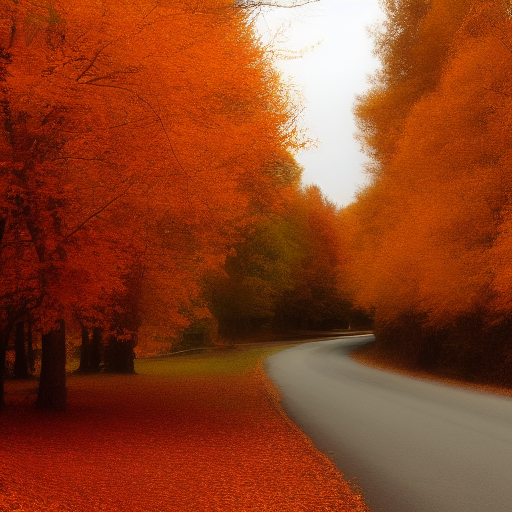

In [6]:
# 이미지 불러오기
# index 0은 그리드 이미지

images[0]

In [7]:
# 이미지 정보

import json

info = json.loads(info_js)
info

{'prompt': 'autumn',
 'all_prompts': ['autumn'],
 'negative_prompt': '',
 'seed': 44,
 'all_seeds': [44],
 'subseed': 359466684,
 'all_subseeds': [359466684],
 'subseed_strength': 0,
 'width': 512,
 'height': 512,
 'sampler_index': 0,
 'sampler': 'Euler a',
 'cfg_scale': 7.0,
 'steps': 20,
 'batch_size': 1,
 'restore_faces': False,
 'face_restoration_model': None,
 'sd_model_hash': '7460a6fa',
 'seed_resize_from_w': -1,
 'seed_resize_from_h': -1,
 'denoising_strength': None,
 'extra_generation_params': {},
 'index_of_first_image': 0}

## # img2img
---

In [ ]:
import math
import os
import sys
import traceback

import numpy as np
from PIL import Image, ImageOps, ImageChops

from modules import devices
from modules.processing import Processed, StableDiffusionProcessingImg2Img, process_images
from modules.shared import opts, state
import modules.shared as shared
import modules.processing as processing
from modules.ui import plaintext_to_html
import modules.images as images
import modules.scripts


def process_batch(p, input_dir, output_dir, args):
    processing.fix_seed(p)

    images = [file for file in [os.path.join(input_dir, x) for x in os.listdir(input_dir)] if os.path.isfile(file)]

    print(f"Will process {len(images)} images, creating {p.n_iter * p.batch_size} new images for each.")

    p.do_not_save_grid = True
    p.do_not_save_samples = True

    state.job_count = len(images) * p.n_iter

    for i, image in enumerate(images):
        state.job = f"{i+1} out of {len(images)}"

        if state.interrupted:
            break

        img = Image.open(image)
        p.init_images = [img] * p.batch_size

        proc = modules.scripts.scripts_img2img.run(p, *args)
        if proc is None:
            proc = process_images(p)

        for n, processed_image in enumerate(proc.images):
            filename = os.path.basename(image)

            if n > 0:
                left, right = os.path.splitext(filename)
                filename = f"{left}-{n}{right}"

            processed_image.save(os.path.join(output_dir, filename))


def img2img(mode: int, prompt: str, negative_prompt: str, prompt_style: str, prompt_style2: str, init_img, init_img_with_mask, init_img_inpaint, init_mask_inpaint, mask_mode, steps: int, sampler_index: int, mask_blur: int, inpainting_fill: int, restore_faces: bool, tiling: bool, n_iter: int, batch_size: int, cfg_scale: float, denoising_strength: float, seed: int, subseed: int, subseed_strength: float, seed_resize_from_h: int, seed_resize_from_w: int, seed_enable_extras: bool, height: int, width: int, resize_mode: int, inpaint_full_res: bool, inpaint_full_res_padding: int, inpainting_mask_invert: int, img2img_batch_input_dir: str, img2img_batch_output_dir: str, *args):
    is_inpaint = mode == 1
    is_batch = mode == 2

    if is_inpaint:
        if mask_mode == 0:
            image = init_img_with_mask['image']
            mask = init_img_with_mask['mask']
            alpha_mask = ImageOps.invert(image.split()[-1]).convert('L').point(lambda x: 255 if x > 0 else 0, mode='1')
            mask = ImageChops.lighter(alpha_mask, mask.convert('L')).convert('L')
            image = image.convert('RGB')
        else:
            image = init_img_inpaint
            mask = init_mask_inpaint
    else:
        image = init_img
        mask = None

    assert 0. <= denoising_strength <= 1., 'can only work with strength in [0.0, 1.0]'

    p = StableDiffusionProcessingImg2Img(
        sd_model=shared.sd_model,
        outpath_samples=opts.outdir_samples or opts.outdir_img2img_samples,
        outpath_grids=opts.outdir_grids or opts.outdir_img2img_grids,
        prompt=prompt,
        negative_prompt=negative_prompt,
        styles=[prompt_style, prompt_style2],
        seed=seed,
        subseed=subseed,
        subseed_strength=subseed_strength,
        seed_resize_from_h=seed_resize_from_h,
        seed_resize_from_w=seed_resize_from_w,
        seed_enable_extras=seed_enable_extras,
        sampler_index=sampler_index,
        batch_size=batch_size,
        n_iter=n_iter,
        steps=steps,
        cfg_scale=cfg_scale,
        width=width,
        height=height,
        restore_faces=restore_faces,
        tiling=tiling,
        init_images=[image],
        mask=mask,
        mask_blur=mask_blur,
        inpainting_fill=inpainting_fill,
        resize_mode=resize_mode,
        denoising_strength=denoising_strength,
        inpaint_full_res=inpaint_full_res,
        inpaint_full_res_padding=inpaint_full_res_padding,
        inpainting_mask_invert=inpainting_mask_invert,
    )
    print(f"\nimg2img: {prompt}", file=shared.progress_print_out)

    p.extra_generation_params["Mask blur"] = mask_blur

    if is_batch:
        assert not shared.cmd_opts.hide_ui_dir_config, "Launched with --hide-ui-dir-config, batch img2img disabled"

        process_batch(p, img2img_batch_input_dir, img2img_batch_output_dir, args)

        processed = Processed(p, [], p.seed, "")
    else:
        processed = modules.scripts.scripts_img2img.run(p, *args)
        if processed is None:
            processed = process_images(p)

    shared.total_tqdm.clear()

    generation_info_js = processed.js()
    if opts.samples_log_stdout:
        print(generation_info_js)

    return processed.images, generation_info_js, plaintext_to_html(processed.info)

### # 파라미터
---

In [ ]:
img_path = '/data/kimgh/ImEzy/stable-diffusion-webui/outputs/txt2img-images/00000-445805258-.png'

mode = 0
prompt = '3D render' # 사용자 입력
negative_prompt = '' # 사용자 입력
prompt_style = ''
prompt_style2 = ''
init_img = Image.open(img_path)
init_img_with_mask = ''
init_img_inpaint = ''
init_mask_inpaint = ''
mask_mode = ''
steps = 20
sampler_index = 0
mask_blur = 1
inpainting_fill = 0
restore_faces = False
tiling = False
n_iter = 1
batch_size = 2
cfg_scale = 10.0 
denoising_strength = 0.35
seed = 44 # 사용자 입력
subseed = -1
subseed_strength = 0
seed_resize_from_h = -1
seed_resize_from_w = -1
seed_enable_extras = True
height = 512 # 사용자 입력
width = 512 # 사용자 입력
resize_mode = 0
inpaint_full_res = True
inpaint_full_res_padding = 0
inpainting_mask_invert = 0
img2img_batch_input_dir = ''
img2img_batch_output_dir = ''

### # 이미지 생성
---

In [ ]:
from difflib import restore


images, info_js, _ = img2img(mode=mode, prompt=prompt, negative_prompt=negative_prompt, prompt_style=prompt_style, prompt_style2=prompt_style2, init_img=init_img, init_img_with_mask=init_img_with_mask,
                        init_img_inpaint=init_img_inpaint, init_mask_inpaint=init_mask_inpaint, mask_mode=mask_mode, steps=steps, sampler_index=sampler_index, mask_blur=mask_blur, inpainting_fill=inpainting_fill,
                        restore_faces=restore_faces, tiling=tiling, n_iter=n_iter, batch_size=batch_size, cfg_scale=cfg_scale, denoising_strength=denoising_strength, seed=seed, subseed=subseed,
                        subseed_strength=subseed_strength, seed_resize_from_h=seed_resize_from_h, seed_resize_from_w=seed_resize_from_w, seed_enable_extras=seed_enable_extras, height=height, width=width,
                        resize_mode=resize_mode, inpaint_full_res=inpaint_full_res, inpaint_full_res_padding=inpaint_full_res_padding, inpainting_mask_invert=inpainting_mask_invert,
                        img2img_batch_input_dir=img2img_batch_input_dir, img2img_batch_output_dir=img2img_batch_output_dir)


img2img: 3D render
100%|██████████| 8/8 [00:03<00:00,  2.62it/s]
Total progress: 8it [00:07,  1.09it/s]


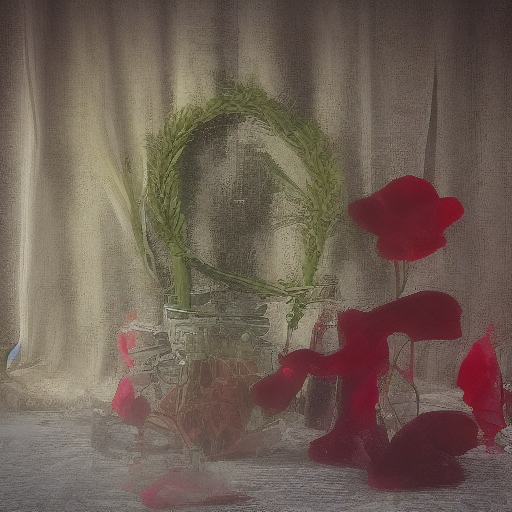

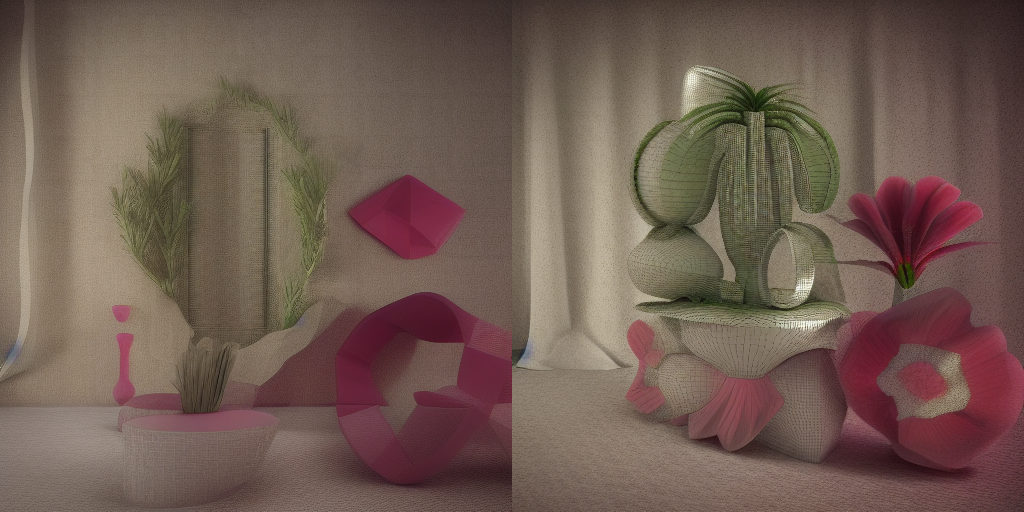

In [ ]:
init_img.show()
images[0].show()

In [ ]:
import json

info = json.loads(info_js)
info

{'prompt': '3D render',
 'all_prompts': ['3D render', '3D render'],
 'negative_prompt': '',
 'seed': 44,
 'all_seeds': [44, 45],
 'subseed': 3953076849,
 'all_subseeds': [3953076849, 3953076850],
 'subseed_strength': 0,
 'width': 512,
 'height': 512,
 'sampler_index': 0,
 'sampler': 'Euler a',
 'cfg_scale': 10.0,
 'steps': 20,
 'batch_size': 2,
 'restore_faces': False,
 'face_restoration_model': None,
 'sd_model_hash': '7460a6fa',
 'seed_resize_from_w': -1,
 'seed_resize_from_h': -1,
 'denoising_strength': 0.35,
 'extra_generation_params': {'Mask blur': 1},
 'index_of_first_image': 1,
 'infotexts': ['3D render\nSteps: 20, Sampler: Euler a, CFG scale: 10.0, Seed: 44, Size: 512x512, Model hash: 7460a6fa, Batch size: 2, Batch pos: 0, Seed resize from: -1x-1, Denoising strength: 0.35, Mask blur: 1',
  '3D render\nSteps: 20, Sampler: Euler a, CFG scale: 10.0, Seed: 44, Size: 512x512, Model hash: 7460a6fa, Batch size: 2, Batch pos: 0, Seed resize from: -1x-1, Denoising strength: 0.35, Mask b